# CALIDAD DE DATOS

## IMPORTAR PAQUETES

In [ ]:
import numpy as np
import pandas as pd
from janitor import clean_names

#Automcompletar rápido
%config IPCompleter.greedy=True

## IMPORTAR LOS DATOS

Sustituir la ruta del proyecto.

In [ ]:
ruta_proyecto = 'C:/Users/mcent/OneDrive/Escritorio/MARTIN/MASTERS/DS4B/DATA SCIENCE/03_MACHINE_LEARNING/07_CASOS/FORECASTING RETAIL'

Sustituir el nombre_fichero_datos.

In [ ]:
nombre_fichero_datos = 'trabajo.csv'

Cargar los datos.

In [ ]:
ruta_completa = ruta_proyecto + '/02_Datos/03_Trabajo/' + nombre_fichero_datos

df = pd.read_csv(ruta_completa,parse_dates=['date'],index_col='date')
df

## VISIÓN GENERAL

In [ ]:
df.info()

## TIPOS DE DATOS

### Identificación

In [ ]:
df.head(2)

In [ ]:
df.dtypes

Conclusión: 

* year, month, y wday deberían ser categóricas

### Corrección

In [ ]:
df = df.astype({'year':'O',
               'month': 'O',
               'wday': 'O'})

df.dtypes

## VALORES ÚNICOS

### Identificación

In [ ]:
df.nunique().sort_values()

### Corrección

In [ ]:
df.drop(columns = ['state_id','cat_id','dept_id'], inplace = True)

## DUPLICADOS

### Identificación

In [ ]:
df.duplicated().sum()

## SEPARAR NUMÉRICAS Y CATEGÓRICAS

### Categóricas

In [ ]:
cat = df.select_dtypes(exclude = 'number').copy()

### Numéricas

In [ ]:
num = df.select_dtypes(include='number').copy()

## GESTIÓN DE CATEGÓRICAS

### Nulos

#### Identificación

In [ ]:
cat.isna().sum().sort_values(ascending = False)

In [ ]:
cat.event_name_1.value_counts(dropna=False)

In [ ]:
cat.event_name_2.value_counts(dropna=False)

In [ ]:
cat.event_type_1.value_counts(dropna=False)

In [ ]:
cat.event_type_2.value_counts(dropna=False)

In [ ]:
pd.crosstab(index=cat['event_name_1'], columns=cat['event_name_2'])

Conclusiones:

* event_name_2 tiene eventos que ya están incluídos en event_name_1
* pero luego al cruzarlos no coinciden
* Esto se debe a que estas fechas han coincidido el mismo día. En EEUU se ha festejado en los playoffs el día del padre.
* en cuanto a los nulos de event_name y event_type parece claro que son días "Sin Festivo", así lo imputaremos

#### Corrección

##### Imputar por un valor

###### Variables a imputar

In [ ]:
var_imputar_valor = ['event_name_1','event_type_1','event_name_2','event_type_2']

###### Valor por el que imputar

In [ ]:
valor = 'Sin Festivo'

###### Imputar

In [ ]:
cat[var_imputar_valor] = cat[var_imputar_valor].fillna(valor)

Comprobamos.

In [ ]:
cat.isna().sum().sort_values(ascending = False)

### Atípicos

#### Categorías poco frecuentes

##### Identificación

In [ ]:
for variable in cat:
    print(variable + '\n')
    print(cat[variable].value_counts(dropna = False))
    print('\n\n')
    

Conclusión:

* No hay variables con categorías raras
* Hay meses con menos registros, esto puede ser porque son los meses con menos de 31 días
* 2015 tiene menos registros ¿serán los de validación o hay más?

Vamos a comprobarlo.

In [ ]:
df.groupby('year').d.nunique()

Parece que faltan 31 días.

Vamos a ver cuales.

In [ ]:
pd.date_range(start = '2015-01-01', end = '2015-12-31' ).difference(df.loc['2015'].index)

Está claro que son los de validación, así que todo correcto.

## GESTIÓN DE NUMÉRICAS

### Estadísticos

In [ ]:
num.describe().T

### Nulos

#### Identificación

In [ ]:
num.isna().sum().sort_values(ascending = False)

sell_price es una variable relevante, vamos a ver si encontramos algún patrón.

In [128]:
#Por producto
df.groupby('item_id').apply(lambda x: x.sell_price.isna().sum()).sort_values(ascending=False)

item_id
FOODS_3_288    71
FOODS_3_090     0
FOODS_3_120     0
FOODS_3_202     0
FOODS_3_252     0
FOODS_3_329     0
FOODS_3_555     0
FOODS_3_586     0
FOODS_3_587     0
FOODS_3_714     0
dtype: int64

In [127]:
#Por nivel de ventas
df.groupby('ventas').apply(lambda x: x.sell_price.isna().sum()).sort_values(ascending=False)

ventas
0      71
210     0
207     0
206     0
205     0
       ..
100     0
99      0
98      0
97      0
763     0
Length: 301, dtype: int64

Solo pasa en un producto y solo los días en los que no hay ventas.

Claramente el motivo es que si no hay ventas no le pone el precio.

Tenemos que corregir esto, ya que es artificial:

* El producto tiene un precio aunque ese día no haya habido ventas

Lo que tendría más sentido es imputar esos nulos por el primer valor válido anterior SEGMENTADO POR PRODUCTO.

Pero podría pasar que el primer día de un producto tuviera ventas cero, lo cual arrastraría los nulos hacia delante sin solucionar el problema.

Así que vamos a imputar por el valor más frecuente del precio de CADA PRODUCTO (la moda).

Esto añade complejidad, ya que necesitamos el producto que no lo tenemos en num.

Así que tenemos que incluirlo temporalmente y después eliminarlo.

##### Añadir el producto

In [ ]:
num = pd.concat([num,cat.item_id], axis = 1)
num

#### Corrección de los nulos de sell_price

##### Calcular el precio más frecuente por producto e imputar

In [ ]:
def imputar_moda(registros):
    #Calcula la moda del precio en ese producto
    moda = registros.sell_price.mode()[0]
    #Imputa los nulos
    registros.loc[registros.sell_price.isna(),'sell_price'] = moda
    #Devuelve todos los registros del producto
    return(registros)

num = num.groupby('item_id').apply(imputar_moda)

Para comprobar que la imputación se ha hecho por producto podemos revisar los valores distintos de precio en cada producto y ver que no haya un salto grande, por ejemplo un salto de 3 a 10.

In [ ]:
num.groupby('item_id').sell_price.value_counts()

##### Eliminar el producto de num

In [ ]:
num.drop(columns = 'item_id',inplace=True)

In [ ]:
num.head()

### Atípicos

#### Por desviación típica

##### Identificación

###### Definir el número de desviaciones típicas

In [ ]:
num_desv_tip = 4

###### Función que devuelve los índices de los atípicos

In [ ]:
def atipicos_desv_tip(variable, num_desv_tip = 4):
    #sacamos los nulos por ahora
    variable = variable.dropna()
    #calculamos los límites
    media = np.mean(variable)
    sd = np.std(variable)
    umbral = sd * num_desv_tip
    lim_inf = media - umbral
    lim_sup = media + umbral
    #encontramos los índices de los que están fuera de los límites
    indices = [indice for indice,valor in variable.items() if valor < lim_inf or valor > lim_sup]
    return(indices)

###### Función que cuenta el número de atípicos

In [ ]:
def conteo_atipicos(df,variable, num_desv_tip = 4):
    atipicos = atipicos_desv_tip(df[variable], num_desv_tip)
    return(df.loc[atipicos,variable].value_counts())

###### Variables a aplicar

In [ ]:
var_atipicos_dt = ['ventas','sell_price']

###### Aplicar

In [ ]:
for variable in var_atipicos_dt:
    print('\n' + variable + ':\n')
    print(conteo_atipicos(num,variable,num_desv_tip))

Parece que puede ser atípicos superiores.

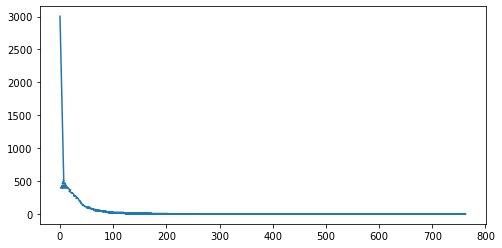

In [ ]:
num.ventas.value_counts().plot(figsize = (8,4));

Conclusión:
    
* Es un claro ejemplo de cola larga, que es muy frecuente en retail
* Mejor no hacer nada por ahora en cuanto a atípicos, en EDA quizá lo veamos mejor

## GUARDAR DATASETS TRAS CALIDAD DE DATOS

Guarda los avances en df, cat y num con un sufijo para poder guardar o recuperar avances del proyecto.

En formato pickle para no perder las modificaciones de metadatos.

### Definir los nombres de los archivos

In [ ]:
ruta_trabajo = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'trabajo_resultado_calidad.pickle'
ruta_cat = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'cat_resultado_calidad.pickle'
ruta_num = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'num_resultado_calidad.pickle'

### Guardar los archivos

In [ ]:
df.to_pickle(ruta_trabajo)
cat.to_pickle(ruta_cat)
num.to_pickle(ruta_num)